# Understanding Ready Operations Filters

In [1]:
from job_shop_lib.benchmarking import load_benchmark_instance
from job_shop_lib.dispatching.rules import (
    DispatchingRuleSolver,
    DispatchingRuleType,
)
from job_shop_lib.dispatching import (
    ReadyOperationsFilterType,
    filter_dominated_operations,
    filter_non_immediate_machines,
    create_composite_operation_filter,
    filter_non_idle_machines,
)
import matplotlib.pyplot as plt

from job_shop_lib import JobShopInstance, Operation

from job_shop_lib.dispatching import (
    ReadyOperationsFilterType,
    create_composite_operation_filter,
)

from job_shop_lib.visualization import (
    create_gantt_chart_video,
    get_partial_gantt_chart_plotter,
)

plt.style.use("ggplot")

In [2]:
CPU = 0
GPU = 1
DATA_CENTER = 2

job_1 = [Operation(CPU, 1), Operation(GPU, 1), Operation(DATA_CENTER, 7)]
job_2 = [Operation(GPU, 5), Operation(DATA_CENTER, 1), Operation(CPU, 1)]
job_3 = [Operation(DATA_CENTER, 1), Operation(CPU, 3), Operation(GPU, 2)]

jobs = [job_1, job_2, job_3]

instance = JobShopInstance(jobs, name="Example")

In [3]:
solver = DispatchingRuleSolver(
    DispatchingRuleType.SHORTEST_PROCESSING_TIME,
    ready_operations_filter=filter_non_idle_machines,
)


create_gantt_chart_video(
    instance=instance,
    video_path="output/example_instance_spt_non_idle_machines_filter.mp4",
    solver=solver,
    remove_frames=False,
    plot_function=get_partial_gantt_chart_plotter(
        show_available_operations=True
    ),
)

In [4]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open(
    "output/example_instance_spt_non_idle_machines_filter.mp4", "rb"
).read()
data_url = (
    "data:output/example_instance_spt_non_idle_machines_filter/mp4;base64,"
    + b64encode(mp4).decode()
)
HTML(
    """
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)

## Benchmarking 

In [5]:
import itertools
import pandas as pd


def print_makespans_for_optimizations(instance, dispatching_rule):
    # print(f"Dispatching rule: {dispatching_rule}")
    # print("-" * 50)

    # Initialize a list to store the results
    results = []

    # Get all the filter types from the enum
    filter_types = list(ReadyOperationsFilterType)

    # Generate all possible combinations of the filters (including the empty set)
    all_combinations = []
    for r in range(len(filter_types) + 1):  # From 0 to N filters
        combinations_r = itertools.combinations(filter_types, r)
        all_combinations.extend(combinations_r)

    # For each combination, run the solver
    for filter_combination in all_combinations:
        if not filter_combination:
            # No filters
            ready_operations_filter = None
            filter_description = "No filter"
        elif len(filter_combination) == 1:
            # Single filter
            ready_operations_filter = filter_combination[0]
            filter_description = f"{filter_combination[0].name} filter"
        else:
            # Multiple filters
            ready_operations_filter = create_composite_operation_filter(
                filter_combination
            )
            filter_names = " & ".join(f.name for f in filter_combination)
            filter_description = f"{filter_names} filters"

        # Solve the scheduling problem with the current filter combination
        schedule = DispatchingRuleSolver(
            dispatching_rule, ready_operations_filter=ready_operations_filter
        ).solve(instance)

        # Get the makespan
        makespan = schedule.makespan()

        # Print the result
        # print(f"Makespan {filter_description}: {makespan}")

        # Append the result to the list
        results.append(
            {"Filter Combination": filter_description, "Makespan": makespan}
        )

    # Create a pandas DataFrame from the results
    df = pd.DataFrame(results)

    return df

In [6]:
help(filter_non_immediate_machines)

Help on function filter_non_immediate_machines in module job_shop_lib.dispatching._ready_operation_filters:

filter_non_immediate_machines(dispatcher: job_shop_lib.dispatching._dispatcher.Dispatcher, operations: list[job_shop_lib._operation.Operation]) -> list[job_shop_lib._operation.Operation]
    Filters out all the operations associated with machines which earliest
    operation is not the current time.



In [7]:
help(filter_dominated_operations)

Help on function filter_dominated_operations in module job_shop_lib.dispatching._ready_operation_filters:

filter_dominated_operations(dispatcher: job_shop_lib.dispatching._dispatcher.Dispatcher, operations: list[job_shop_lib._operation.Operation]) -> list[job_shop_lib._operation.Operation]
    Filters out all the operations that are dominated.
    An operation is dominated if there is another operation that ends before
    it starts on the same machine.



In [8]:
help(filter_non_idle_machines)

Help on function filter_non_idle_machines in module job_shop_lib.dispatching._ready_operation_filters:

filter_non_idle_machines(dispatcher: job_shop_lib.dispatching._dispatcher.Dispatcher, operations: list[job_shop_lib._operation.Operation]) -> list[job_shop_lib._operation.Operation]
    Filters out all the operations associated with non-idle machines.

    A machine is considered idle if there are no ongoing operations
    currently scheduled on it. This filter removes operations that are
    associated with machines that are busy (i.e., have at least one
    uncompleted operation).

    Utilizes :meth:``Dispatcher.ongoing_operations()`` to determine machine
    statuses.

    Args:
        dispatcher: The dispatcher object.
        operations: The list of operations to filter.

    Returns:
        The list of operations that are associated with idle machines.



In [9]:
ta01 = load_benchmark_instance("ta01")
ta01

JobShopInstance(name=ta01, num_jobs=15, num_machines=15)

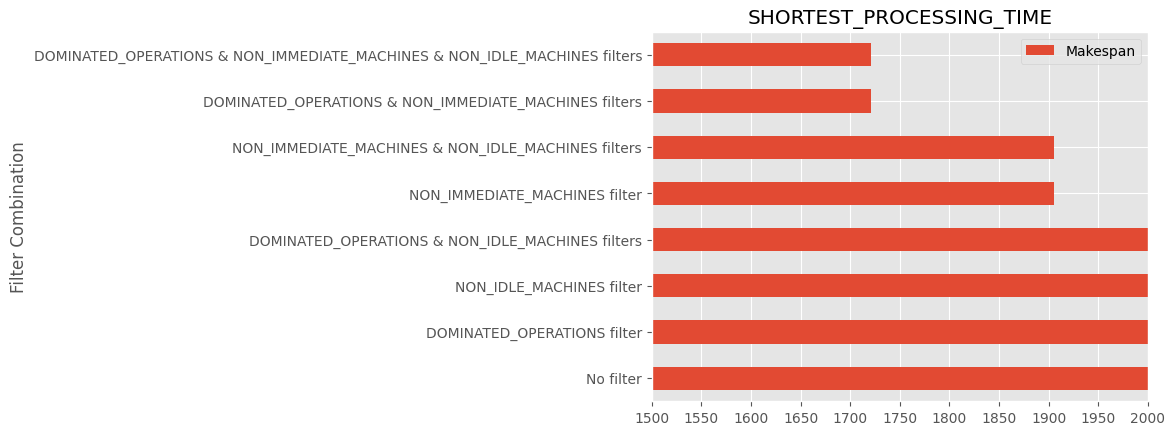

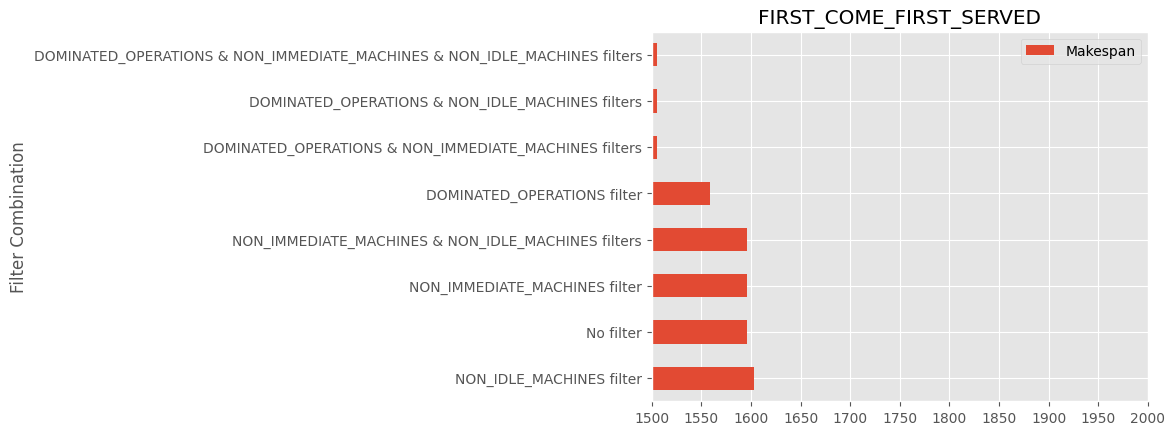

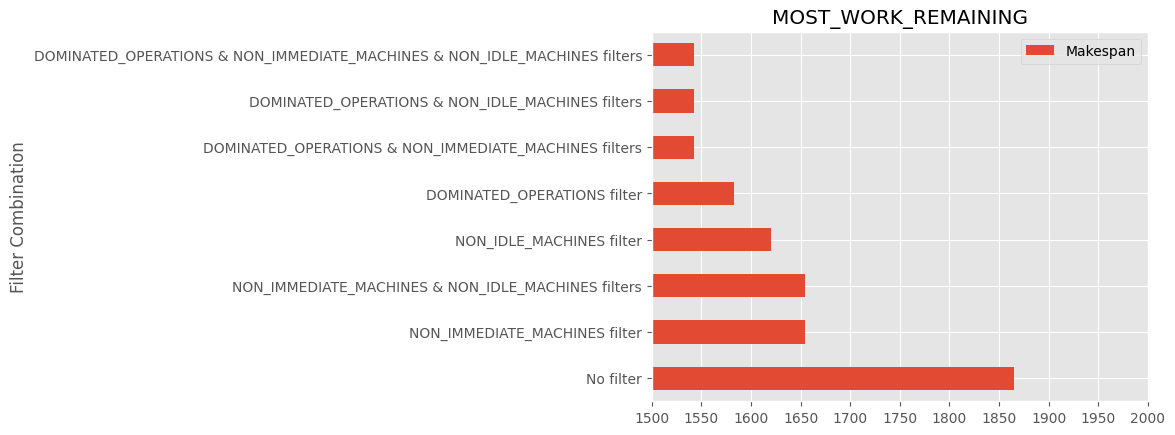

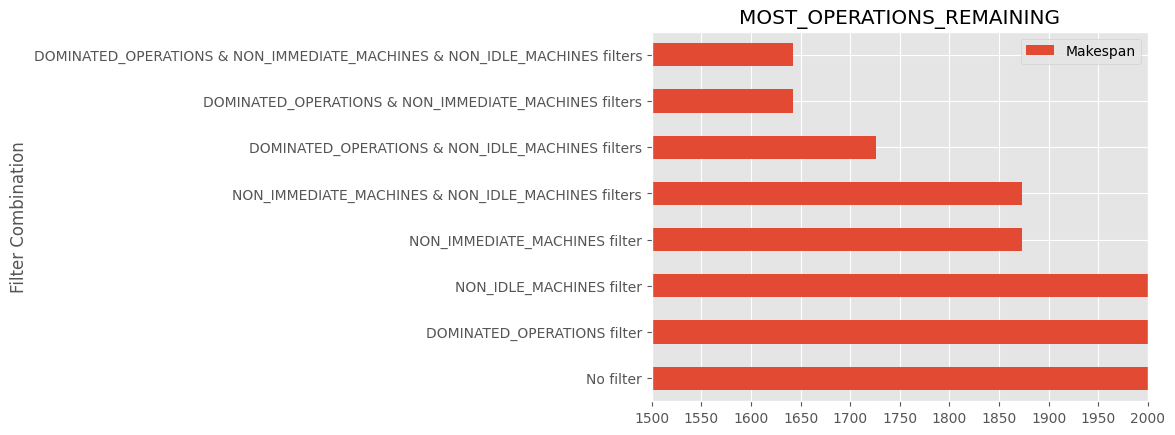

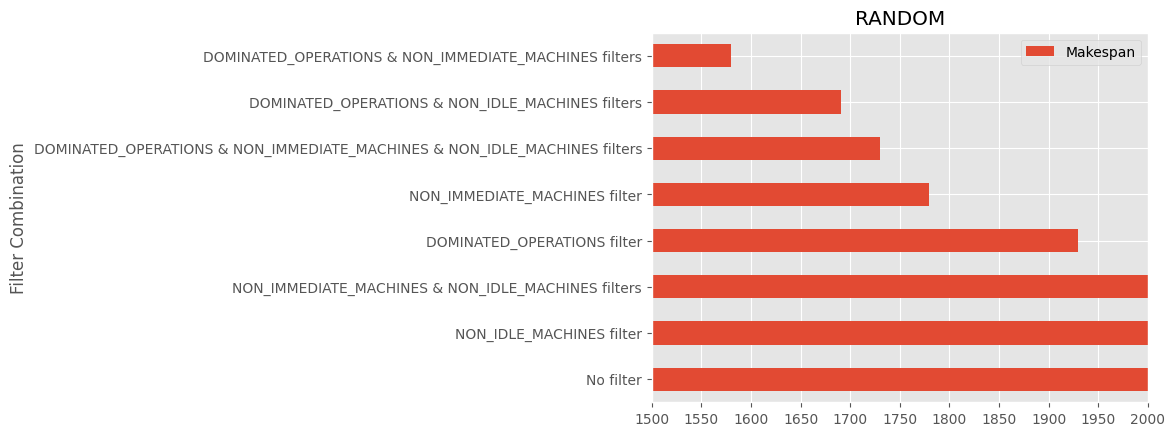

In [10]:
dfs = []
for pdr in DispatchingRuleType:
    df = print_makespans_for_optimizations(ta01, pdr)
    print()
    # Chamge the number of xticks to 10
    df.sort_values(by="Makespan", ascending=False).plot.barh(x="Filter Combination", y="Makespan", title=pdr.name, xlim=(1500, 2000), xticks=range(1500, 2001, 50))
    dfs.append(df)

<Axes: title={'center': 'Average Makespan'}, ylabel='Filter Combination'>

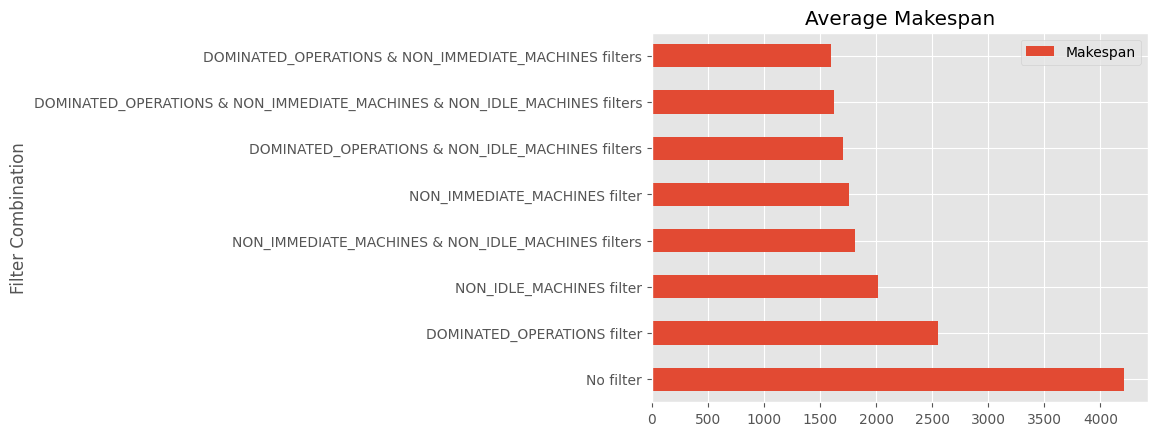

In [11]:
df_combined = pd.concat(dfs, keys=[pdr.name for pdr in DispatchingRuleType])

df_combined.groupby("Filter Combination").agg("mean").sort_values(by="Makespan", ascending=False).plot.barh(title="Average Makespan")